# Kobe Bryant Statistics: INFO 4604 / Applied Machine Learning 
by: Lucas Bouchard, Harold Chang, Steven Rauthus, Justin Klemplar

Summarization: In this notebook, we demonstrate the ability to create a machine learning algorithm that is able to use a dataset containing NBA player Kobe Bryant's career statisics and predict whether a particular action type "shot selection" is successful or missed using binary classification

### What are we classifying? (Predicting)
##### (1)Kobe shot made based on distance to basket, shot selection, …(all features)(predict)
##### (2)How likely is a shot to go in based on the distance to the basket?(predict)
##### (3)How likely is Kobe to win a game based on his (features)(which feature you mean?)(predict)
##### (4)Where are Kobes strongest and weakest shooting zones?(chart/analysis)
##### (5)Over his entire career was Kobe a more accurate 3-point or 2-point shooter?(chart/analysis)
##### (6)What year/game/playoff series was Kobe the most accurate in his shooting percentage?(chart/analysis)
##### (7)Was Kobe a more accurate shooter in the playoffs or regular season?(chart/analysis)
##### (8)What was Kobe’s most accurate type of shot? (Dunk, Jump-Shot, Layup, Bank-Shot)(chart/analysis)
##### (9)What year did Kobe make/miss the most attempted shots?(chart/analysis)

# Notebook Bookmarks:
    
    - Go to Top of Notebook
    - Go to Clean and EDA
    - Go to Feature Selection and Creation
    - Go to Train Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

/Users/Steven/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/Steven/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Steven/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.

In [2]:
df = pd.read_csv("data.csv")

# Start of Clean and EDA

In [3]:
df.head(2)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2


In [4]:
#Remove Useless data
df.drop(['lat', 'lon','team_name','team_id'], axis=1, inplace=True)

In [5]:
#convert game_date to date time dtype
df['game_date']=df['game_date'].apply(lambda x: x.split('-')).apply(lambda y: pd.datetime(int(y[0]),int(y[1]),int(y[2])))

Making binary columns for "matchup"

In [6]:
#df.matchup.value_counts()
df['matchup']=df['matchup'].apply(lambda x: 1 if '@' in x else 0)


Making binary columns for "shot_type" (3pt/2pt)

In [7]:
#df.shot_type.value_counts()
df['shot_type']=df['shot_type'].apply(lambda x: 1 if '3' in x else 0)

In [8]:
#df=pd.get_dummies(df)

In [9]:
df.head(1)

,action_type,combined_shot_type,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,season,...,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,167,72,10,1,0,2000-01,...,18,NaN,0,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,1,POR,1


In [10]:
df.action_type.value_counts()

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

# There are too many action types with few occurances. Here we filtered out Kobe Bryant's 20 most common action types and placed the other ones under the category "other."


In [11]:
most_common_action_types = df['action_type'].value_counts()[20:]
common_types = most_common_action_types.index.values

df.loc[df['action_type'].isin(common_types), 'action_type'] = 'Other'
df['action_type'].value_counts()

Jump Shot                     18880
Layup Shot                     2567
Driving Layup Shot             1978
Turnaround Jump Shot           1057
Fadeaway Jump Shot             1048
Running Jump Shot               926
Other                           816
Pullup Jump shot                476
Turnaround Fadeaway shot        439
Slam Dunk Shot                  411
Reverse Layup Shot              395
Jump Bank Shot                  333
Driving Dunk Shot               310
Dunk Shot                       262
Tip Shot                        182
Alley Oop Dunk Shot             122
Step Back Jump shot             118
Floating Jump shot              114
Driving Reverse Layup Shot       97
Hook Shot                        84
Driving Finger Roll Shot         82
Name: action_type, dtype: int64

In [12]:
df['period'].value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

We then combined periods 5-7 into a single category "overtime"

In [13]:
overtime = np.array([5, 6, 7])
df.loc[df['period'].isin(overtime), 'period'] = 'overtime'
df['period'].value_counts()

3           8296
1           8048
4           7260
2           6718
overtime     375
Name: period, dtype: int64

In [14]:
df.dtypes

action_type                   object
combined_shot_type            object
game_event_id                  int64
game_id                        int64
loc_x                          int64
loc_y                          int64
minutes_remaining              int64
period                        object
playoffs                       int64
season                        object
seconds_remaining              int64
shot_distance                  int64
shot_made_flag               float64
shot_type                      int64
shot_zone_area                object
shot_zone_basic               object
shot_zone_range               object
game_date             datetime64[ns]
matchup                        int64
opponent                      object
shot_id                        int64
dtype: object

# Here we set an index and converted some of the data types to "category" for better summmerization purposes

In [15]:
df.set_index('shot_id', inplace=True)
df["action_type"] = df["action_type"].astype('object')
df["combined_shot_type"] = df["combined_shot_type"].astype('category')
df["game_event_id"] = df["game_event_id"].astype('category')
df["game_id"] = df["game_id"].astype('category')
df["period"] = df["period"].astype('object')
df["playoffs"] = df["playoffs"].astype('category')
df["season"] = df["season"].astype('category')
df["shot_made_flag"] = df["shot_made_flag"].astype('category')
df["shot_type"] = df["shot_type"].astype('category')
#df["team_id"] = df["team_id"].astype('category')

In [16]:
df.head(1)

,action_type,combined_shot_type,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,167,72,10,1,0,2000-01,27,18,NaN,0,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,1,POR


In [17]:
df.dtypes

action_type                   object
combined_shot_type          category
game_event_id               category
game_id                     category
loc_x                          int64
loc_y                          int64
minutes_remaining              int64
period                        object
playoffs                    category
season                      category
seconds_remaining              int64
shot_distance                  int64
shot_made_flag              category
shot_type                   category
shot_zone_area                object
shot_zone_basic               object
shot_zone_range               object
game_date             datetime64[ns]
matchup                        int64
opponent                      object
dtype: object

# Here we looked at a few descriptive statisitics

In [18]:
df.shape

(30697, 20)

In [19]:
#Categorical Columns
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697
unique,21,6,620,1559,5,2,20,2.0,2,6,7,5,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,0,Center(C),Mid-Range,Less Than 8 ft.,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,1978


In [20]:
#Numerical Columns
df.describe(include=['number']).loc[["mean","min","max"]]

,loc_x,loc_y,minutes_remaining,seconds_remaining,shot_distance,matchup
mean,7.110499,91.107535,4.885624,28.365085,13.437437,0.512786
min,-250.000000,-44.000000,0.000000,0.000000,0.000000,0.000000
max,248.000000,791.000000,11.000000,59.000000,79.000000,1.000000


# Data Visualization

Here we look at our selected target class('shot_made_flag) to check for dataset imbalances

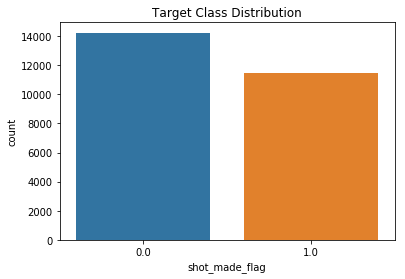

In [21]:
xy = plt.axes()
sns.countplot(x='shot_made_flag', data=df, ax=xy);
xy.set_title('Target Class Distribution')
plt.show()

Based on this, we can see that our target variable is distributed quite equally and will not require any action to deal with imbalance

In [235]:
#Seeing how many missing values there are 

In [230]:
#df.dropna(subset=['shot_made_flag'], inplace=True)

In [242]:
#NOT SURE IF THIS STEP IS NECESSARY YET
#Creating dummies for categorical features

categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(df[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    df.drop(cc, axis=1, inplace=True)
    df = df.join(dummies)

KeyError: 'action_type'

# Feature Selection

Now we begin seperating the data into two parts - one for learning and one for testing. 

In [238]:
NaN_shots = df['shot_made_flag'].isnull()

training_df = df[NaN_shots].drop('shot_made_flag', 1)
data = df[~NaN_shots]

X = df.drop('shot_made_flag', 1)
Y = df['shot_made_flag']

In [239]:
threshold = 0.9
vt = VarianceThreshold().fit(X)

feat_var_threshold = X.columns[vt.variances_ > threshold * (1-threshold)].values
feat_var_threshold

ValueError: could not convert string to float: 'IND'

In [ ]:
Random forest Classifier 